In [1]:
import gc
import os
import pandas as pd
import utils.paths as plh
import matplotlib.pyplot as plt
import utils.read_utils as hlpread

# Paths #

In [2]:
PROJECT_ROOT = plh.get_project_root()
PROJECT_ROOT

WindowsPath('F:/github_workspace/employee_access_resource_classifier')

In [3]:
train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.training_data_folder.folder'),
                          hlpread.read_yaml_key('data_source.training_data_folder.train'),
                        )


test_data = os.path.join(PROJECT_ROOT, 
                         hlpread.read_yaml_key('data_source.data_folders'),
                         hlpread.read_yaml_key('data_source.training_data_folder.folder'),
                         hlpread.read_yaml_key('data_source.training_data_folder.test'),
                        )

(train_data, test_data)

('F:\\github_workspace\\employee_access_resource_classifier\\data\\training\\train.csv',
 'F:\\github_workspace\\employee_access_resource_classifier\\data\\training\\test.csv')

# Initial Analysis #

## Training ##

In [4]:
train = hlpread.read_csv(train_data)
pd.concat([train.head(), train.sample(5), train.tail()], axis = 0)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
25146,1,77359,14731,117961,118446,118447,118321,117906,290919,118322
27610,1,42437,11525,117910,117911,117920,118568,129510,19721,118570
2018,1,18072,16900,118256,118257,118623,126684,193644,292795,126685
1541,1,31825,5201,117961,118343,118979,307024,159672,118331,118332
2273,1,104958,7551,117961,118052,118867,118321,117906,290919,118322


### Description of the features: ###
* Label : ACTION is 1 if access is granted to the resource and 0 if not granted.
* Features
    - RESOURCE - An ID for each resource
    - MGR_ID - The EMPLOYEE ID of the manager of the current EMPLOYEE ID record. An employee may have only one manager at a time.
    - ROLE_ROLLUP_1 - Company role grouping category id 1 (e.g. US Engineering)
    - ROLE_ROLLUP_2 - Company role grouping category id 2 (e.g. US Retail)
    - ROLE_DEPTNAME - Company role department description (e.g. Retail)
    - ROLE_TITLE - Company role business title description (e.g. Senior Engineering Retail Manager)
    - ROLE_FAMILY_DESC - Company role family extended description (e.g. Retail Manager, Software Engineering)
    - ROLE_FAMILY - Company role family description (e.g. Retail Manager)
    - ROLE_CODE - Company role code; this code is unique to each role (e.g. Manager)

In [5]:
print(f'Columns: {train.columns}')
print(f'Number of records {train.shape}')

Columns: Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')
Number of records (32769, 10)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [7]:
train.duplicated().sum()

0

In [8]:
train.isna().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

Text(1, 1897, '1897')

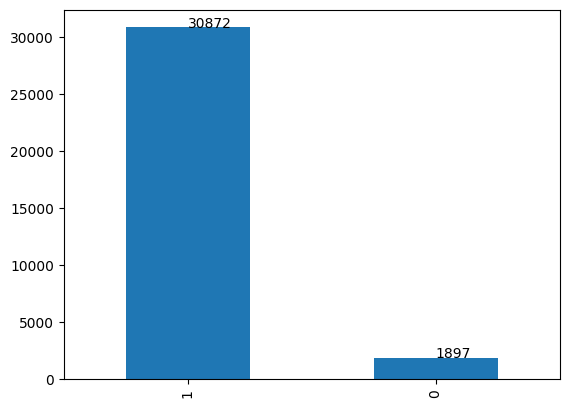

In [9]:
label_cnts = train.ACTION.value_counts()
label_cnts.plot(kind = 'bar')
plt.text(0,label_cnts[1],label_cnts[1])
plt.text(1,label_cnts[0],label_cnts[0])

In [10]:
train.nunique(axis = 0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

### Initial observation: ###
* Total 7518 unique RESOURCE we need to classify ACCESS for.
* Do not have any missing and duplicate records.
* We have inbalance dataset with unequal distribution of RESOURCE access where most of the RESOURCE have access to and very few denied RESOURCE. To better understand we need to check based on the each RESOURCE_ID
* Can reduce the size of the features
    - Label feature "ACTION" is of type int64 which can be change to bit/bool.
    - Other interger feature, can also change the data type of int32.
* All features are catagorical feature encode as interger.
* RESOURCE, MGR_ID and ROLE_FAMILY_DESC are high-cardinality categorical features. That means they have a lot of unique values and that makes them harder to encode.
* ROLE_CODE and ROLE_TITLE have exactly the same amount of unique values.

In [11]:
#If we do not consider "MGR_ID" we reduce the record by 2300 
train['IS_DUPLICATE'] = train.duplicated(['ACTION', 'RESOURCE', 
                                          'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 
                                          'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY','ROLE_CODE'
                                        ])

train['IS_DUPLICATE'].sum()

print(f'Shape before: {train.shape[0]}')
print('Shape after drop: '+str(train.shape[0] - train['IS_DUPLICATE'].sum())) 

Shape before: 32769
Shape after drop: 30396


In [12]:
train[train.IS_DUPLICATE].ACTION.value_counts()

1    2316
0      57
Name: ACTION, dtype: int64

### Observartion: ###

* "MGR_ID" are EMPLOYEE_ID of the managers of the current EMPLOYEE_ID record. Employee join or leave the organization all the time, value of this feature will change. Since any organization EMPLOYEE_ID are always unique for any employee joining the organization. So will drop "MGR_ID" for classification.


## Test ##

In [5]:
test = hlpread.read_csv(test_data)

print(f'Number of records {train.shape}')
pd.concat([test.head(), test.sample(5), test.tail()], axis = 0)

Number of records (32769, 10)


,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425
35065,35066,28149,71171,117961,118386,123844,118784,121556,290919,118786
21883,21884,15064,15214,117902,118041,121678,118028,121679,117887,118030
26582,26583,80470,5016,117961,118343,121710,120789,250337,118424,120791
42840,42841,15064,22846,117961,117969,19666,179731,124389,117887,117973
10195,10196,15716,22854,117902,118041,131461,119778,174194,19721,119779


In [14]:
test.nunique(axis = 0)

id                  58921
RESOURCE             4971
MGR_ID               4689
ROLE_ROLLUP_1         126
ROLE_ROLLUP_2         177
ROLE_DEPTNAME         466
ROLE_TITLE            351
ROLE_FAMILY_DESC     2749
ROLE_FAMILY            68
ROLE_CODE             351
dtype: int64

#### Question: Can it be possible if there any new RESOURCE or Values in any of the feature that is not available in the training dataset ? #### 

In [15]:
set(test[['RESOURCE']].drop_duplicates()) - set(train[['RESOURCE']].drop_duplicates())

set()

In [16]:
set(test[['ROLE_ROLLUP_1']].drop_duplicates()) - set(train[['ROLE_ROLLUP_1']].drop_duplicates())

set()

In [17]:
set(test[['ROLE_ROLLUP_2']].drop_duplicates()) - set(train[['ROLE_ROLLUP_2']].drop_duplicates())

set()

In [18]:
set(test[['ROLE_DEPTNAME']].drop_duplicates()) - set(train[['ROLE_DEPTNAME']].drop_duplicates())

set()

In [19]:
set(test[['ROLE_TITLE']].drop_duplicates()) - set(train[['ROLE_TITLE']].drop_duplicates())

set()

In [20]:
set(test[['ROLE_FAMILY_DESC']].drop_duplicates()) - set(train[['ROLE_FAMILY_DESC']].drop_duplicates())

set()

In [21]:
set(test[['ROLE_FAMILY']].drop_duplicates()) - set(train[['ROLE_FAMILY']].drop_duplicates())


set()

In [22]:
set(test[['ROLE_CODE']].drop_duplicates()) - set(train[['ROLE_CODE']].drop_duplicates())

set()

In [23]:
del test
gc.collect()


126

### Observation: ###
* There are no data/records that are only present in test dataset and not in train dataset.
* We should be able to handel this in our model as for any organization new resource are added all the time. Model should have provision to handel these cases.